🔄 Lade vorhandenes Modell...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


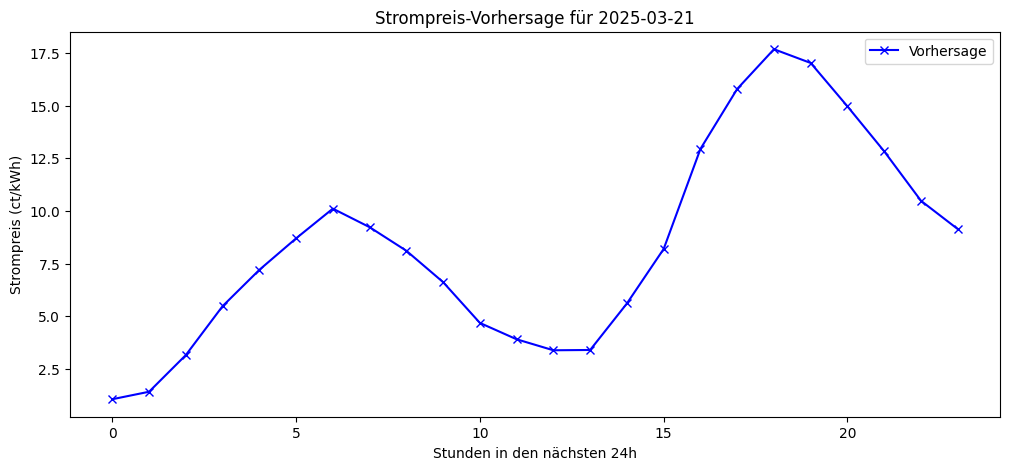

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from datetime import datetime, timedelta

# Dateipfad
file_path = "/Users/Andre/vscode-projects/BI-Steel-Project/machine_learning/energy_prices_data.csv"
model_path = "energy_price_model.h5"  

# Lade die Daten
df = pd.read_csv(file_path, sep=';', decimal=',')
df['Datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['von'], format='%d.%m.%Y %H:%M')
df = df[['Datetime', 'Spotmarktpreis in ct/kWh']]
df.rename(columns={'Spotmarktpreis in ct/kWh': 'Spotpreis'}, inplace=True)
df.set_index('Datetime', inplace=True)

# Normalisiere die Daten
scaler = MinMaxScaler(feature_range=(0, 1))
df['Spotpreis'] = scaler.fit_transform(df[['Spotpreis']])


# Sequenzen erstellen
def create_sequences(data, seq_length=336, output_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length - output_length):
        X.append(data[i:i + seq_length])  # 14 Tage Input
        y.append(data[i + seq_length:i + seq_length + output_length])  # 24 Stunden Output
    return np.array(X), np.array(y)


seq_length = 336  # 14 Tage
output_length = 24  # 24 Stunden Vorhersage

# Konvertiere die Spotpreis-Daten in ein Array
data = df['Spotpreis'].values
X, y = create_sequences(data, seq_length, output_length)

X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-Test-Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Modell laden oder erstellen
if os.path.exists(model_path):
    print("🔄 Lade vorhandenes Modell...")
    model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
else:
    print("🆕 Erstelle neues Modell...")
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        LSTM(50),
        Dense(output_length) 
    ])
    model.compile(optimizer='adam', loss='mse')

# Falls Modell neu erstellt, trainiere es und speichere es
if not os.path.exists(model_path):  
    model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))
    model.save(model_path)  


# Hier wird der neueste Zeitraum für die Vorhersage genommen
latest_data = np.array([data[-seq_length:]])  # Nimm die letzten 14 Tage (336 Stunden)
latest_data = latest_data.reshape((1, seq_length, 1))  # Reshape für das Modell
predictions = model.predict(latest_data)  # Vorhersage für die nächsten 24 Stunden

# Transformiere die Vorhersage zurück auf den originalen Preisbereich
predictions = scaler.inverse_transform(predictions)

# Plot der Vorhersage
plt.figure(figsize=(12, 5))
plt.plot(predictions[0], label="Vorhersage", marker='x', color='b')
plt.xlabel("Stunden in den nächsten 24h")
plt.ylabel("Strompreis (ct/kWh)")
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


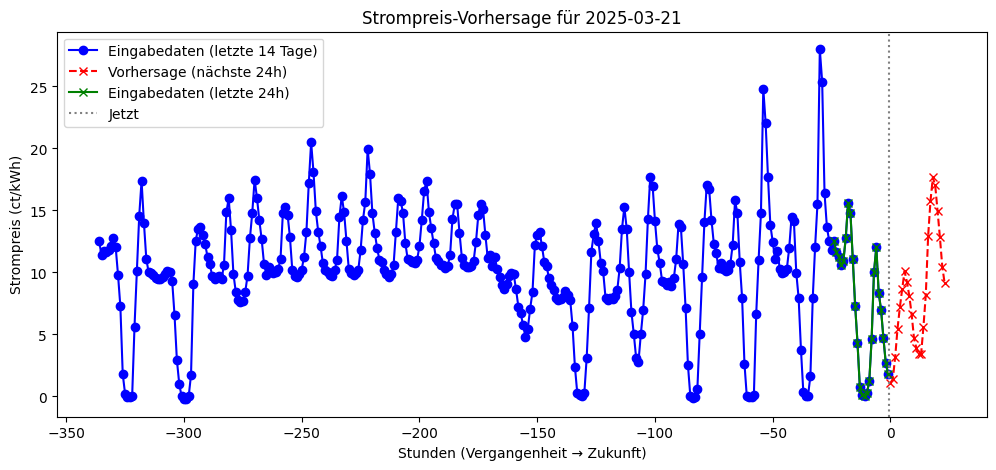

In [2]:
# Vorhersage mit den letzten 14 Tagen der Daten (336 Stunden)
latest_data = np.array([data[-seq_length:]])  # Nimm die letzten `seq_length` Werte der Daten
latest_data = latest_data.reshape((1, seq_length, 1))  # Reshaping für das LSTM-Modell

# Vorhersage der nächsten 24 Stunden
predictions = model.predict(latest_data)

# Rücktransformation der Vorhersagen in den Originalbereich
predictions = scaler.inverse_transform(predictions)

# Letzte 24 Stunden der Eingabedaten (zur Visualisierung)
input_last_24h = scaler.inverse_transform(data[-24:].reshape(-1, 1)).flatten()

# Plot
plt.figure(figsize=(12, 5))

# Plot für die echten Daten der letzten 14 Tage (stundenweise)
plt.plot(range(-seq_length, 0), scaler.inverse_transform(data[-seq_length:].reshape(-1, 1)).flatten(), label="Eingabedaten (letzte 14 Tage)", marker='o', linestyle='-', color='blue')

# Plot für die Vorhersagen der nächsten 24 Stunden
plt.plot(range(0, output_length), predictions[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Plot der letzten 24 Stunden der Eingabedaten
plt.plot(range(-24, 0), input_last_24h, label="Eingabedaten (letzte 24h)", marker='x', linestyle='-', color='green')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (Vergangenheit → Zukunft)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit und Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")

# Plot anzeigen
plt.show()


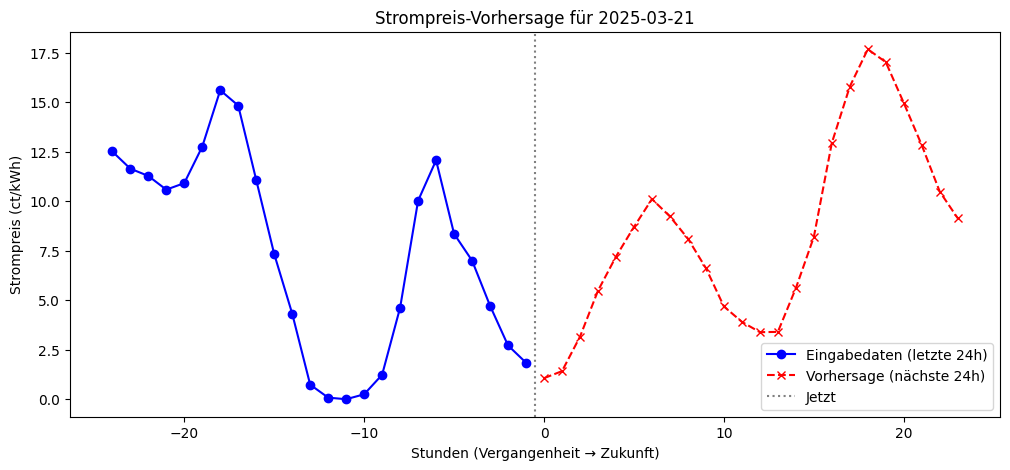

In [3]:
plt.figure(figsize=(12, 5))

# Letzte 24 Stunden aus den Input-Daten holen (zur Visualisierung)
input_last_24h = scaler.inverse_transform(data[-24:].reshape(-1, 1)).flatten()

# Plot für die echten Daten der letzten 24h
plt.plot(range(-24, 0), input_last_24h, label="Eingabedaten (letzte 24h)", marker='o', linestyle='-', color='blue')

# Plot für die Vorhersagen der nächsten 24h
plt.plot(range(0, 24), predictions[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (Vergangenheit → Zukunft)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit/Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage für {datetime.now().strftime('%Y-%m-%d')}")

plt.show()


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Vorhersage auf dem Testdatensatz
y_pred = model.predict(X_test)

# Rücktransformation der Vorhersagen und echten Werte
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Berechnung des Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, y_pred)

# Berechnung des Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Ausgabe der Metriken
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


715/715 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step
Mean Squared Error (MSE): 30.757024266186775
Root Mean Squared Error (RMSE): 5.545901573791837


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


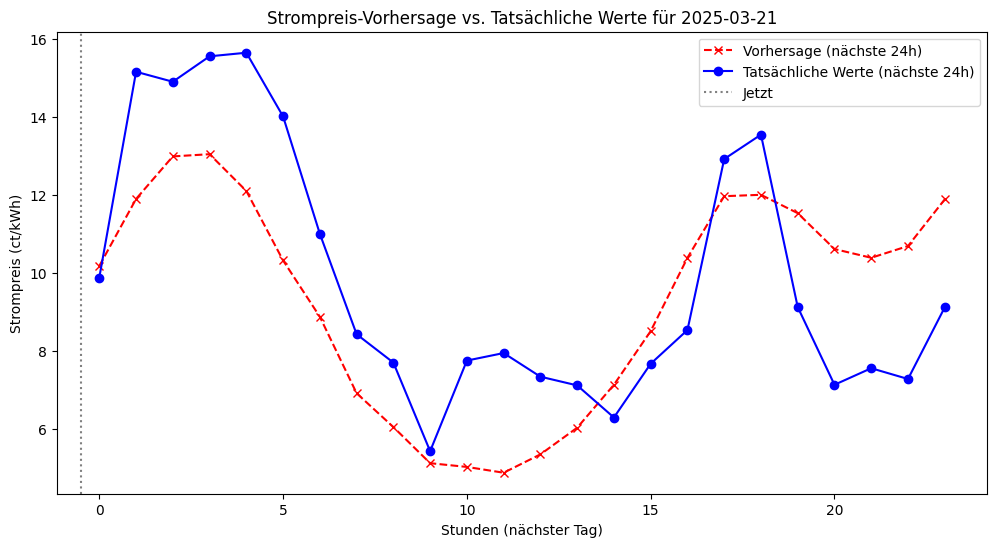

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Holen des Index für die aktuellen 24 Stunden (der letzte Testdatensatz für den heutigen Tag)
today = datetime.now().strftime('%Y-%m-%d')

# Gehe davon aus, dass die Zeitstempel der tatsächlichen Daten mit den Vorhersage-Daten übereinstimmen
today_data = df[df.index.date == datetime.today().date()]  # Aktuelle Daten für heute
today_data = today_data[['Spotpreis']]  # Nur Spotpreise (kWh)

# Wählen eines zufälligen Index im Testdatensatz (der heutigen Stunde)
random_index = np.random.randint(0, len(X_test))  # Wir können auch einen Index nehmen, der zu 'today' gehört, aber hier nehmen wir einen zufälligen

# Hole die Eingabedaten und die tatsächlichen Ausgabewerte (y_test) für den zufälligen Index
input_data = X_test[random_index]
true_values = y_test[random_index]

# Mache eine Vorhersage für diesen Index
prediction = model.predict(input_data.reshape(1, seq_length, 1))

# Rücktransformation der Vorhersage und der tatsächlichen Werte
prediction = scaler.inverse_transform(prediction)
true_values = scaler.inverse_transform(true_values.reshape(1, -1))

# Plot der Vorhersage und der tatsächlichen Werte
plt.figure(figsize=(12, 6))

# Plot für die Vorhersage
plt.plot(range(24), prediction[0], label="Vorhersage (nächste 24h)", marker='x', linestyle='--', color='red')

# Plot für die tatsächlichen Werte
plt.plot(range(24), true_values[0], label="Tatsächliche Werte (nächste 24h)", marker='o', linestyle='-', color='blue')

# Achsenbeschriftungen und Titel
plt.xlabel("Stunden (nächster Tag)")
plt.ylabel("Strompreis (ct/kWh)")
plt.axvline(x=-0.5, color='gray', linestyle='dotted', label="Jetzt")  # Trennlinie zwischen Vergangenheit/Zukunft
plt.legend()
plt.title(f"Strompreis-Vorhersage vs. Tatsächliche Werte für {today}")

# Anzeigen des Plots
plt.show()
